In [2]:
import collections

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns

In [3]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    im = ax.imshow(data, **kwargs)

    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=20)

    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels, fontsize=16)
    ax.set_yticklabels(row_labels, fontsize=16)
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    for _, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    return im, cbar

In [4]:
sns.set_style('white')

In [5]:
df = pd.read_csv('datasets/symptoms_period.csv')
df = df.sort_values(by='period')
df_indexed = df.set_index(keys=['period'], drop=False)
periods = df_indexed['period'].unique().tolist()
dfs_train = [df[df.period == period] for period in periods]

In [6]:
symptoms = pd.read_csv('datasets/symptom_questions.csv')
symptoms = symptoms.iloc[:, 2:3]
symptoms = [s.strip() for s in np.asarray(symptoms).flatten()]

## Picking out symptoms out of the dataset

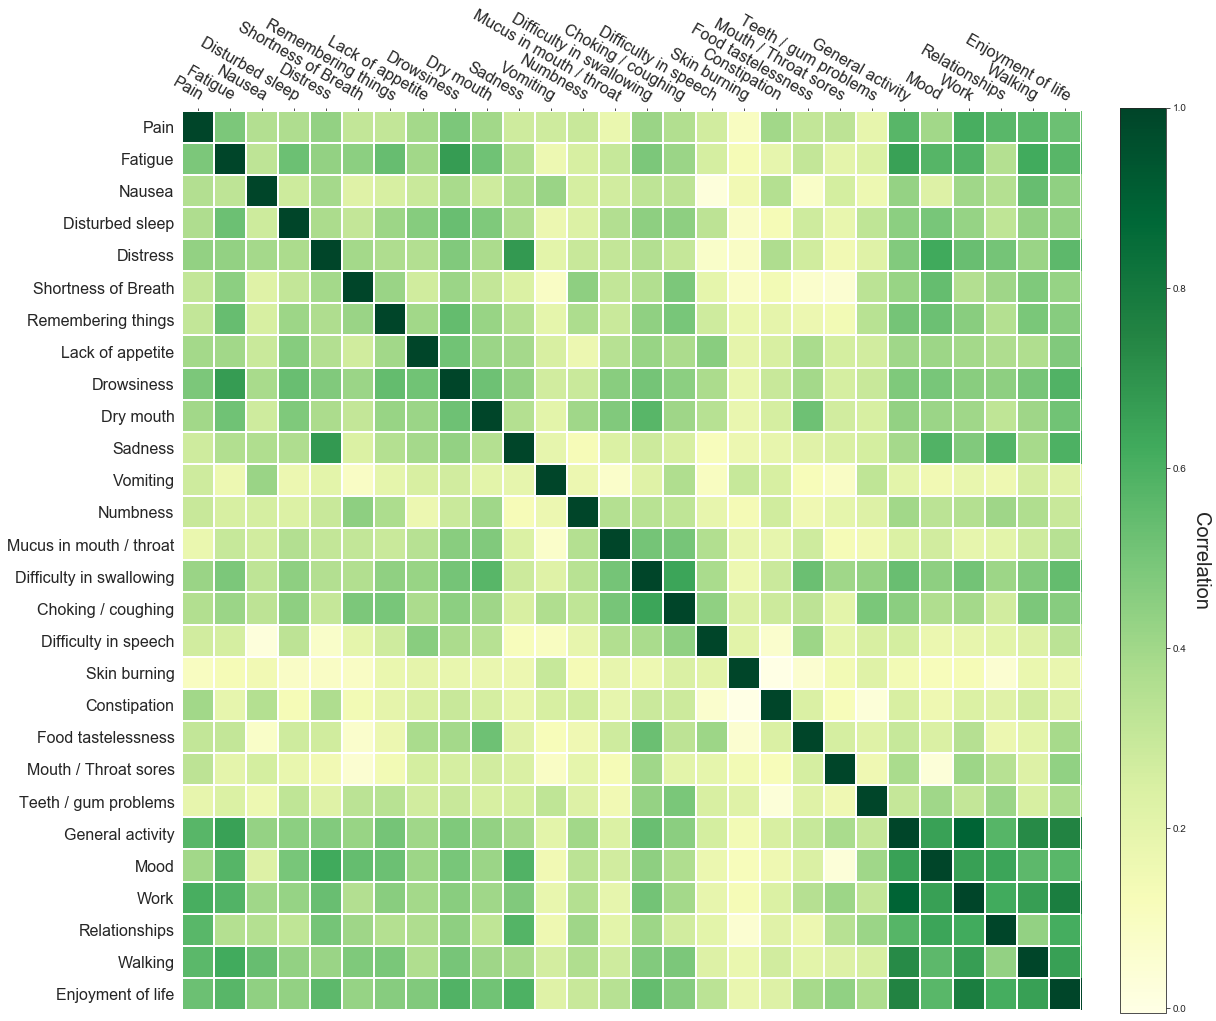

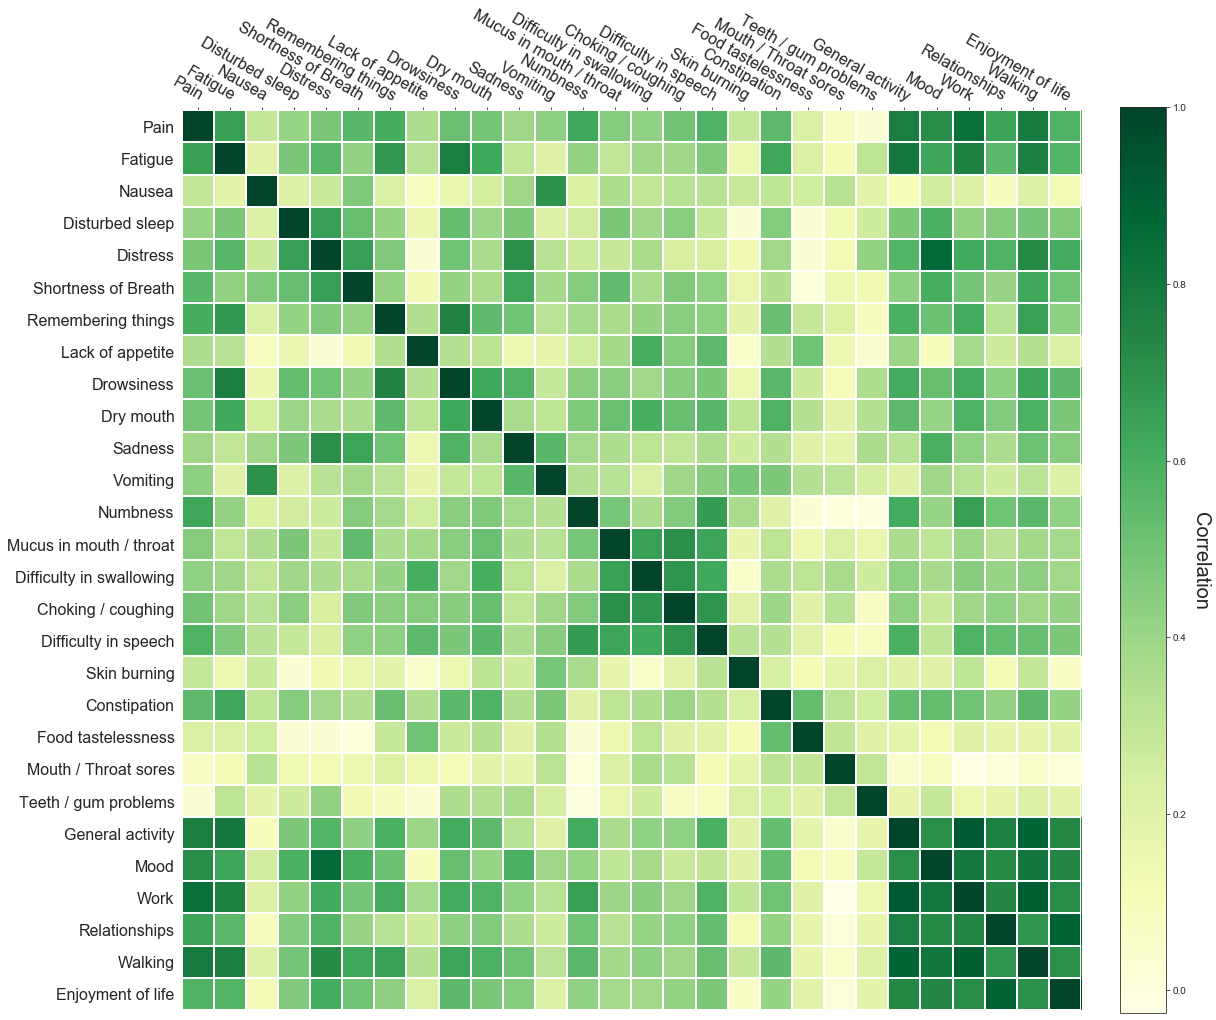

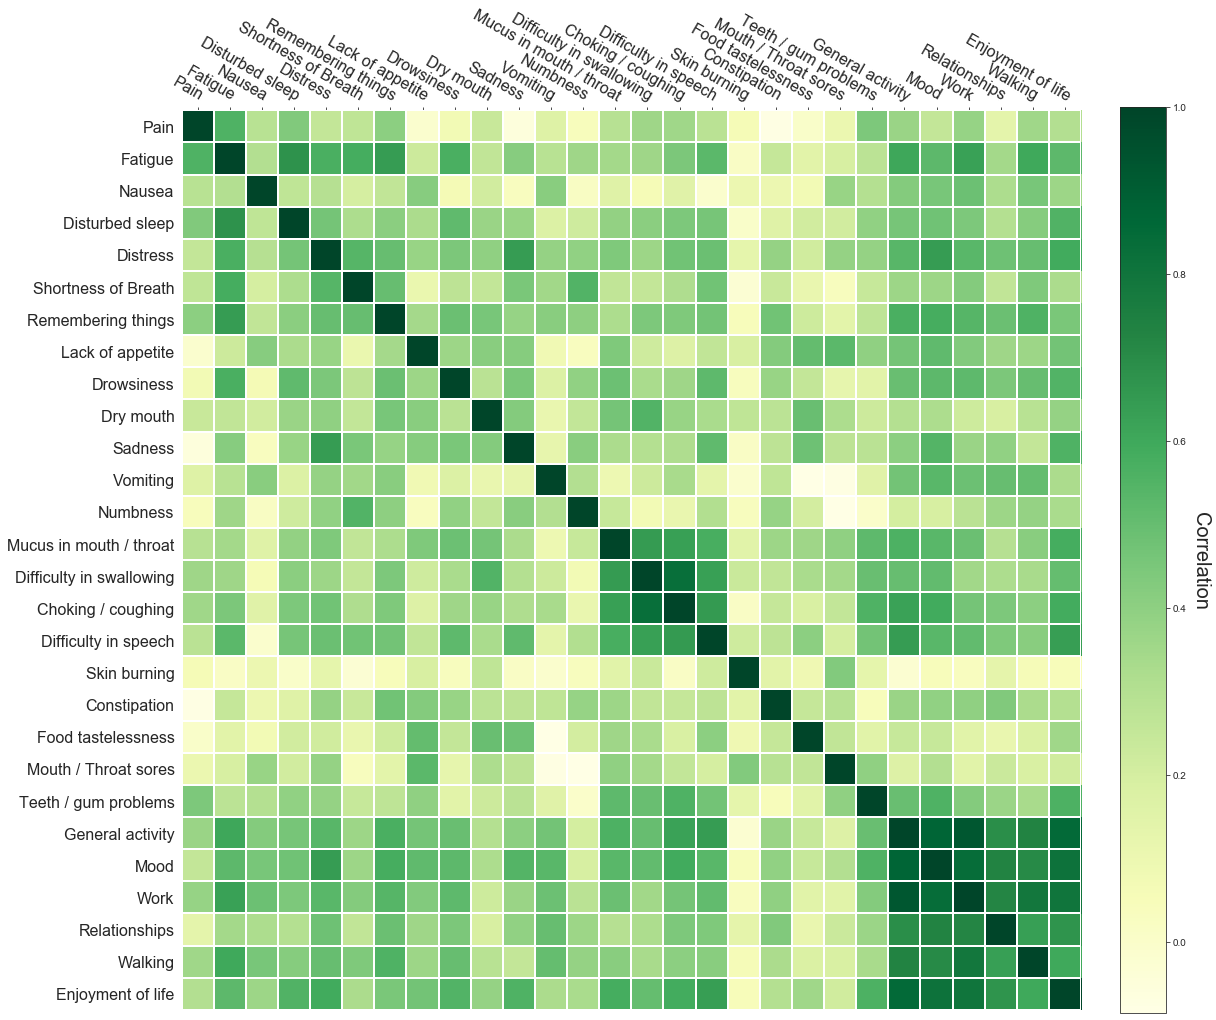

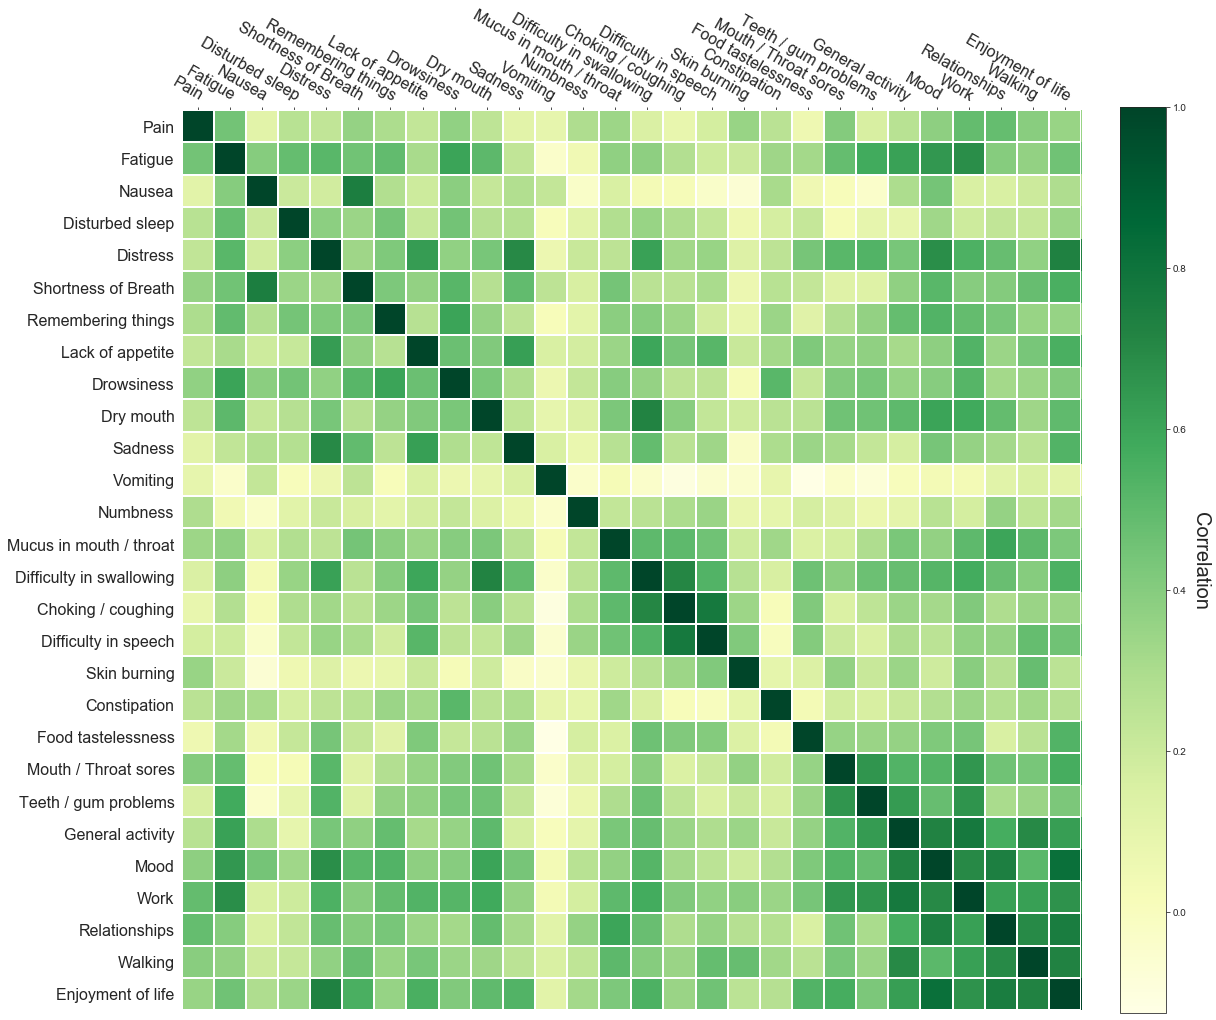

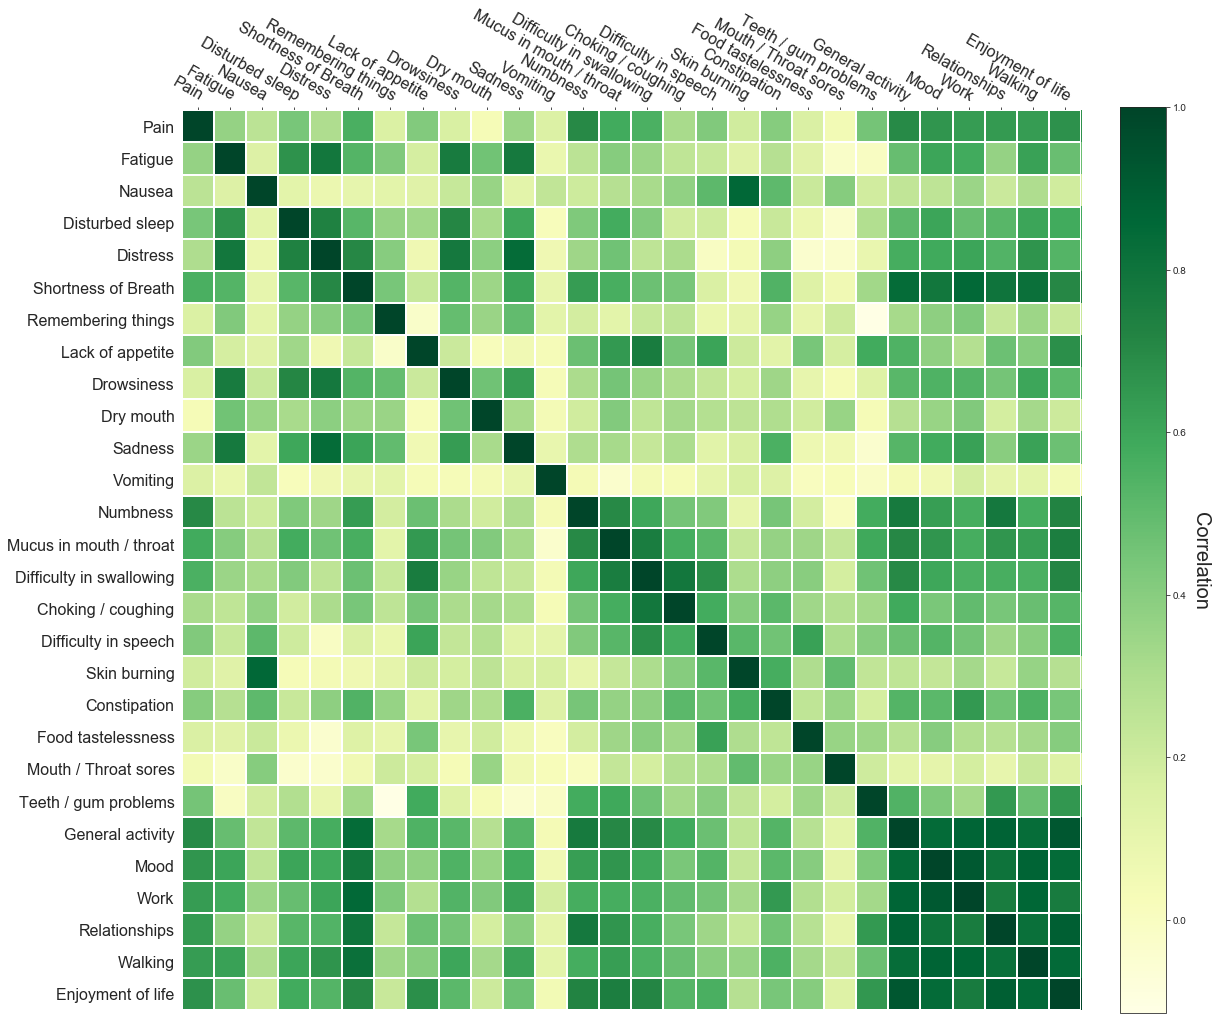

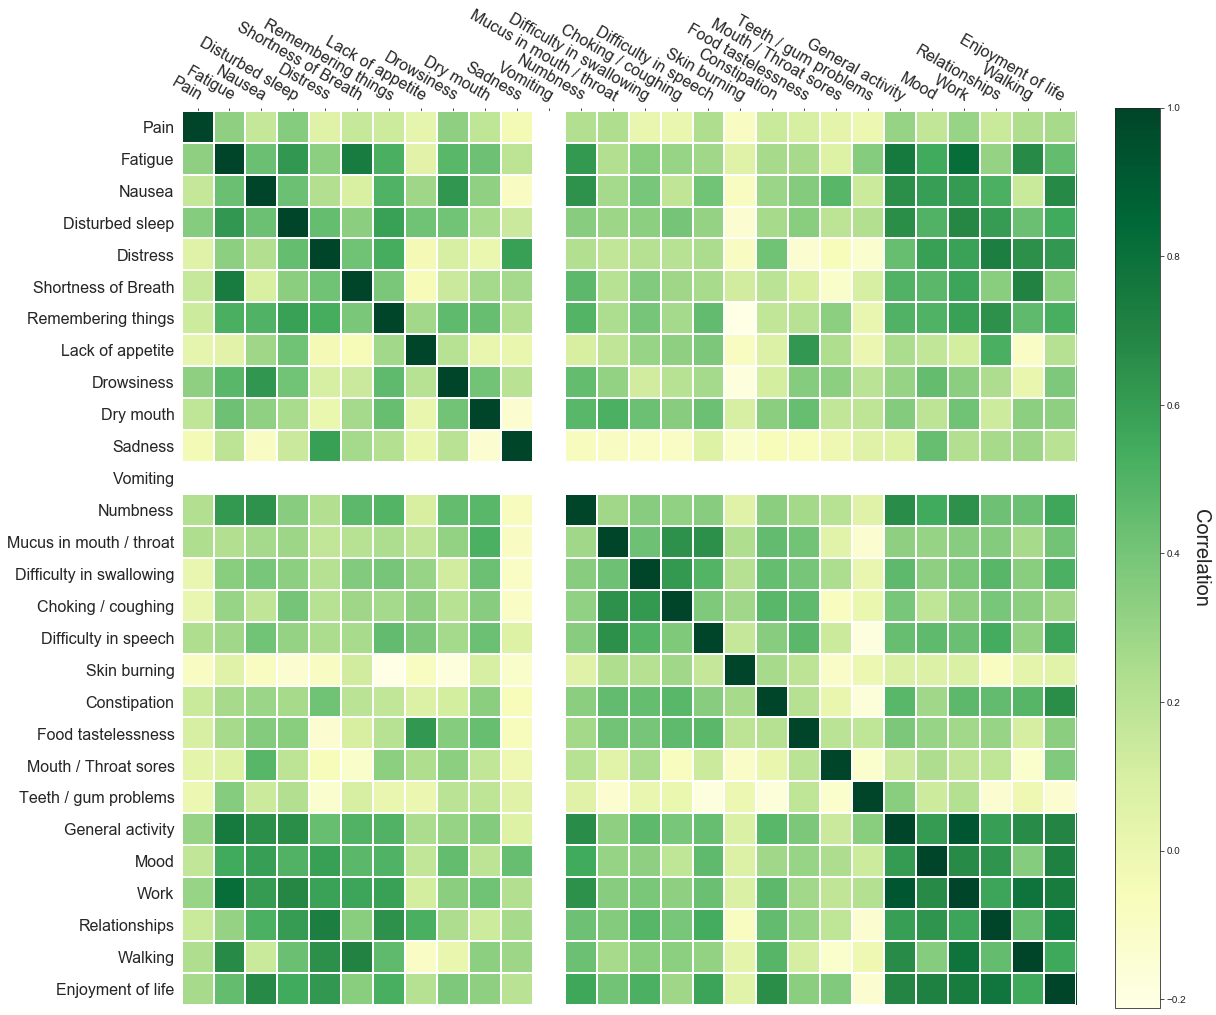

In [9]:
for df_train in dfs_train:
    period = df_train['period'].iloc[0]
    X = df_train.iloc[:,3:31]
    X = X.fillna(0)
    X = X.astype('int64')
    corr = X.corr(method='pearson')
    fig = plt.figure(figsize = (17,17))
    ax = fig.add_subplot(111)

    img, cbar = heatmap(corr, symptoms, symptoms, 
                        ax=ax, cmap='YlGn', cbarlabel='Correlation', 
                        cbar_kw={'fraction': 0.046, 'pad': 0.04},
                        interpolation='nearest')
#    ax.set_title(f"Correlation matrix - time {'upto ' + str(period) if period % 6 == 0 else 'after ' + str(period) } months", fontsize=20)
    fig.tight_layout()
    plt.show()
    fig.savefig(f'output/correlation/{period}.svg', dpi=100, transparent=True)

## Let's check PCA variance ratio if used

In [7]:
variance_ratios = {}
for df_train in dfs_train:
    period = df_train['period'].iloc[0]
    X = df_train.iloc[:,3:31]
    X = X.fillna(0)
    X = X.astype('int64')
    pca = PCA(n_components=2, random_state=1)
    X_PCA = pca.fit_transform(X)
    variance_ratios[period] = (pca.explained_variance_ratio_.cumsum()[1])
variance_ratios

{0: 0.5026919382083462,
 6: 0.5810093412213571,
 12: 0.5301737105618793,
 18: 0.5152183456493048,
 24: 0.6204795141198788,
 25: 0.5109243202539926}

## Elbow fitting - finding out no. of clusters that can be formed

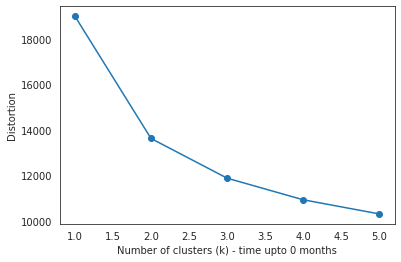

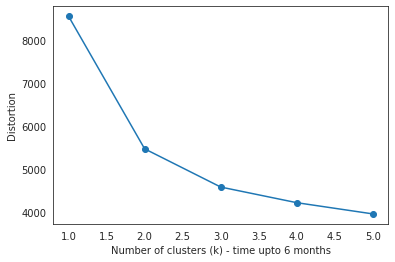

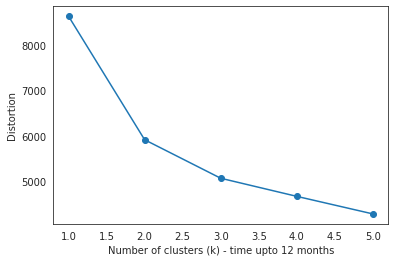

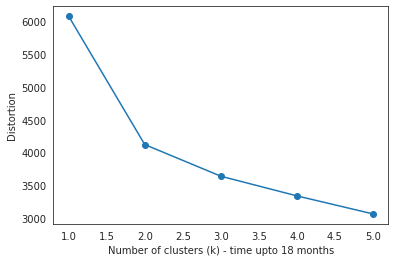

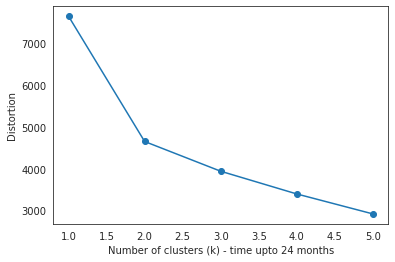

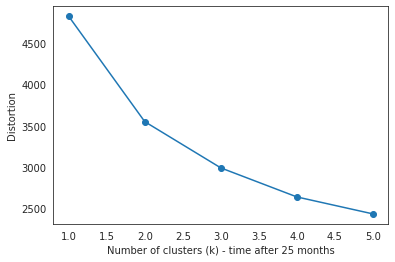

In [8]:
for df_train in dfs_train:
    period = df_train['period'].iloc[0]
    X = df_train.iloc[:,3:31]
    X = X.fillna(0)
    X = X.astype('int64')

    distortions = []
    K_to_try = range(1, 6)

    for i in K_to_try:
        model = KMeans(
                n_clusters=i,
                init='k-means++',
                # n_init=10,
                # max_iter=300,
                # n_jobs=-1,
                random_state=1)
        model.fit(X)
        distortions.append(model.inertia_)

    plt.plot(K_to_try, distortions, marker='o')
    plt.xlabel(f"Number of clusters (k) - time {'upto ' + str(period) if period % 6 == 0 else 'after ' + str(period) } months")
    plt.ylabel('Distortion')
    plt.show()

Seems like 3 is a good fit for the clusters

Going ahead and making PCA and non PCA fits for k means model

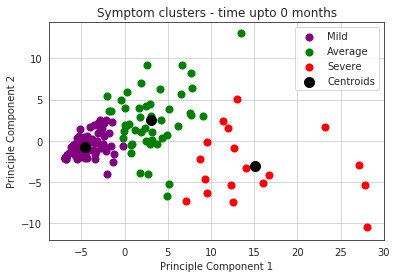

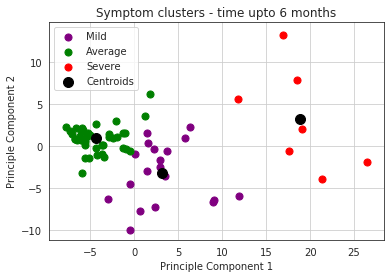

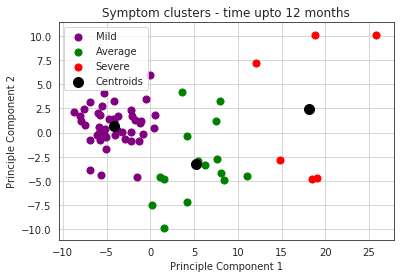

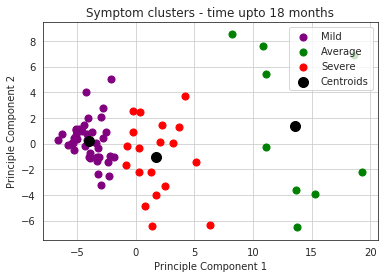

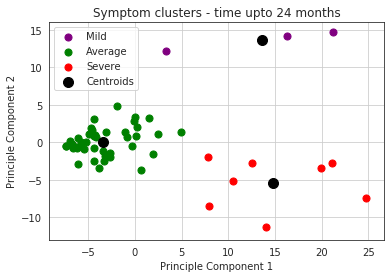

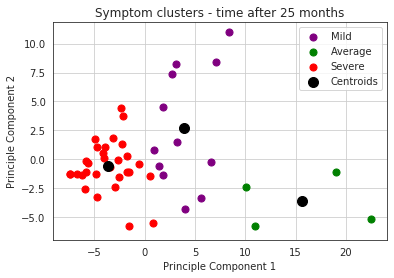

In [9]:
datasets = {}
for df_train in dfs_train:
    period = df_train['period'].iloc[0]
    X = df_train.iloc[:,3:31]
    X = X.fillna(0)
    X = X.astype('int64')
    pca = PCA(n_components=2, random_state=1)
    X_PCA = pca.fit_transform(X)
    
    model = KMeans(
        n_clusters=3,
        init='k-means++',
        # n_init=10,
        # max_iter=300,
        # n_jobs=-1,
        random_state=1)

    model = model.fit(X_PCA)

    y = model.predict(X_PCA)
    datasets[period] = {'x': X_PCA, 'y': y}

    plt.scatter(X_PCA[y == 0, 0], X_PCA[y == 0, 1], s = 50, c = 'purple', label = 'Mild')
    plt.scatter(X_PCA[y == 1, 0], X_PCA[y == 1, 1], s = 50, c = 'green', label = 'Average')
    plt.scatter(X_PCA[y == 2, 0], X_PCA[y == 2, 1], s = 50, c = 'red', label = 'Severe')
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
    plt.title(f"Symptom clusters - time {'upto ' + str(period) if period % 6 == 0 else 'after ' + str(period) } months")
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    plt.legend()
    plt.grid()
    plt.show()

### Cluster count

In [10]:
[{'period': period, 'count': collections.Counter(data['y'])} for period, data in datasets.items()]

[{'period': 0, 'count': Counter({1: 48, 0: 91, 2: 18})},
 {'period': 6, 'count': Counter({0: 19, 1: 44, 2: 7})},
 {'period': 12, 'count': Counter({0: 45, 2: 6, 1: 15})},
 {'period': 18, 'count': Counter({2: 19, 0: 39, 1: 9})},
 {'period': 24, 'count': Counter({1: 46, 2: 8, 0: 3})},
 {'period': 25, 'count': Counter({0: 12, 2: 30, 1: 4})}]

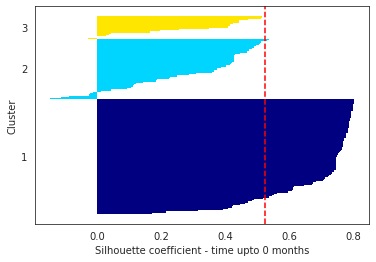

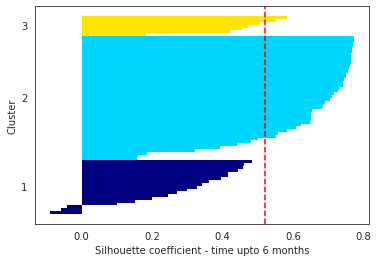

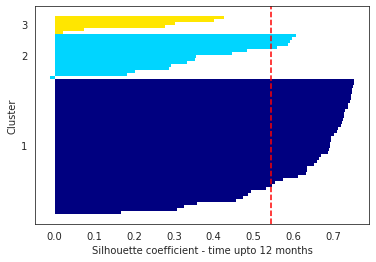

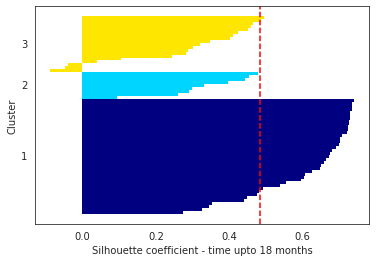

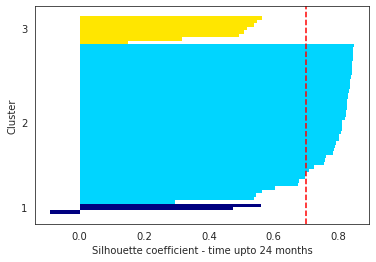

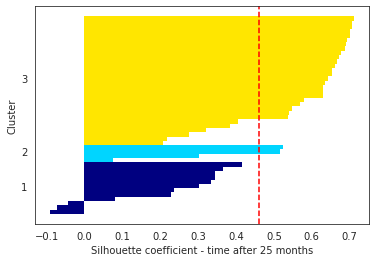

In [11]:
for period, data in datasets.items():
    y = data['y']
    X_PCA = data['x']
    cluster_labels = np.unique(y)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X_PCA, y, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                c_silhouette_vals,
                height=1.0,
                edgecolor='none',
                color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)

    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel(f"Silhouette coefficient - time {'upto ' + str(period) if period % 6 == 0 else 'after ' + str(period) } months")
    plt.show()

In [12]:
datasets_final = {}
for df_train in dfs_train:
    period = df_train['period'].iloc[0]
    X = df_train.iloc[:,3:31]
    X = X.fillna(0)
    X = X.astype('int64')
    
    # use best k from Elbow method
    model_k = KMeans(
        n_clusters=3,
        init='k-means++',
        # n_init=10,
        # max_iter=300,
        # n_jobs=-1,
        random_state=1)

    # fit with X instead of X_pca
    model_k = model_k.fit(X)
    y_final = model_k.predict(X)
    datasets_final[period] = {'x': X, 'y': y_final}

[{'period': period, 'count': collections.Counter(data['y'])} for period, data in datasets_final.items()]

[{'period': 0, 'count': Counter({2: 46, 1: 105, 0: 6})},
 {'period': 6, 'count': Counter({2: 17, 0: 47, 1: 6})},
 {'period': 12, 'count': Counter({1: 46, 2: 5, 0: 15})},
 {'period': 18, 'count': Counter({1: 20, 0: 38, 2: 9})},
 {'period': 24, 'count': Counter({1: 46, 2: 8, 0: 3})},
 {'period': 25, 'count': Counter({1: 34, 0: 10, 2: 2})}]

In [13]:
index = 0
for period, data in datasets_final.items():
    X = data['x']
    y_final = data['y']
    ids = dfs_train[index].patientId
    X = pd.concat([X, ids], axis=1)
    y_final = pd.DataFrame(y_final, columns=['cluster'])

    raw_result = pd.concat([X, y_final], axis=1)
    raw_result = raw_result[np.isfinite(raw_result['patientId'])]
    raw_result = raw_result.fillna(0)
    raw_result = raw_result.astype('int')
    raw_result.to_csv(f'output/raw_result-time-{period}.csv', index=False)
    index += 1